In [18]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy import geocoders
from geopy.geocoders import Nominatim
#!conda install -c conda-forge folium
import folium # map rendering library
from folium import map
from pandas.io.json import json_normalize
import os
from pylab import figure, axes, pie, title, show
import matplotlib.cm as cm
import matplotlib.colors as colors

In [19]:
# Web scrape Wikipedia Population data
url='https://en.wikipedia.org/wiki/List_of_cities_in_Minnesota'
res=requests.get(url)
soup=BeautifulSoup(res.content,'lxml')
soup.title.text
tdata=soup.find('table',attrs={'class':'wikitable'})
tdata_rows=tdata.find_all('tr')

# converting soup data into list that can be added to Pandas dataframe
city_name_list=[]
census_list=[]
county_list=[]

df=pd.DataFrame()
# looping through the table entries and appending to the list
for tr in tdata_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    if not len(row)==0:
        city_name_list.append(row[1])
        census_list.append(row[2])
        county_list.append(row[5])       
        
# creating Pandas dataframe
df['City']=city_name_list
df['City'].replace('Saint','St.', regex=True,inplace=True)
df['Census_2019']=census_list
df['County']=county_list
df.replace('\n','',regex=True,inplace=True)
df.replace(' †','',regex=True,inplace=True)
df.replace('†','',regex=True,inplace=True)
df.head()

# Web scrape Patch safest neighborhood data
url='https://www.alarms.org/safest-cities-in-minnesota/'
res=requests.get(url)
soup=BeautifulSoup(res.content,'lxml')
soup.title.text
tdata=soup.find('table',attrs={'class':'tablepress'})
tdata_rows=tdata.find_all('tr')

# converting soup data into list that can be added to Pandas dataframe
city_name_list=[]
violent_crime_rate_list=[]
property_crime_list=[]
law_enforce_list=[]
Total_crime_list=[]

df_safety=pd.DataFrame()
# looping through the table entries and appending to the list
for tr in tdata_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    if not len(row)==0:
        city_name_list.append(row[1])
        violent_crime_rate_list.append(row[8])
        property_crime_list.append(row[9])
        law_enforce_list.append(row[10])
        Total_crime_list.append(row[6])
     
# creating Pandas dataframe
df_safety['City']=city_name_list
df_safety['Violent Crime per 1000']=violent_crime_rate_list
df_safety['Property Crime per 1000']=property_crime_list
df_safety['Law Enforcement per 1000']=law_enforce_list
df_safety['Total Crime']=Total_crime_list
df_safety.replace('\n','',regex=True,inplace=True)
df_safety.head()

# Merge above data as per Neighborhood name
print('The shape of df is: ', df.shape)
print('The shape of df_safety is: ', df_safety.shape)
df_city_data=pd.merge(df,df_safety,on='City',how='left')
df_city_data.dropna(inplace=True)
print('The shape of merged dataframe is: ',df_city_data.shape)
df_city_data.reset_index(drop=True)

# Formatting the dataset
df_city_numeric=df_city_data[df_city_data.columns.difference(['City','County'])].replace(',','',regex=True).astype(float)
df_city_string=df_city_data[['City','County']]
df_city_data['Census_2019']=df_city_data['Census_2019'].replace(',','',regex=True).astype(float)
df_city_data['Violent Crime per 1000']=df_city_data['Violent Crime per 1000'].replace(',','',regex=True).astype(float)
df_city_data['Property Crime per 1000']=df_city_data['Property Crime per 1000'].replace(',','',regex=True).astype(float)
df_city_data['Law Enforcement per 1000']=df_city_data['Law Enforcement per 1000'].replace(',','',regex=True).astype(float)
df_city_data['Total Crime']=df_city_data['Total Crime'].replace(',','',regex=True).astype(float)
df_city_data.reset_index(drop=True,inplace=True)
df_city_data['Crime per 1000']=1000*df_city_data['Total Crime'].div(df_city_data['Census_2019'])

# Collect Lat, Long information for each Neighborhood from Geocoder - add to dataframe
if os.path.isfile(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\MN_data.csv')==False:    
    latitude_list=[]
    longitude_list=[]
    for ind in df_city_data.index:
        address= df_city_data['City'][ind]+',Minnesota'
        geolocator = Nominatim(user_agent="MN_explorer")
        location = geolocator.geocode(address)
        if location.latitude=='None':
            latitude_list.append('') 
        else:
            latitude_list.append(location.latitude)
        if location.longitude=='None':
            longitude_list.append('') 
        else:
            longitude_list.append(location.longitude)
    df_city_data['latitude']=latitude_list
    df_city_data['longitude']=longitude_list
else:
    df_city_data=pd.read_csv(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\MN_data.csv')




The shape of df is:  (506, 3)
The shape of df_safety is:  (83, 5)
The shape of merged dataframe is:  (81, 7)


In [20]:
# use foursquare API to explore neighborhoods
CLIENT_ID = 'N4YAJTTLXROSADV1JN2RK14GR541CJYUKOTP03SEZ3115N12' # your Foursquare ID
CLIENT_SECRET = 'HVXBQDL0YAGAWO4WNV4IIUNSDIELPSSLX0A1BCU4EL421ATR' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
# function that extracts nearby venues  
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
    
if os.path.isfile(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\MN_grouped.csv')==False:
    minnesota_venues=getNearbyVenues(names=df_city_data['City'],latitudes=df_city_data['latitude'],longitudes=df_city_data['longitude'])   
    minnesota_venues.groupby('Neighborhood').count()
    print('There are {} uniques categories.'.format(len(minnesota_venues['Venue Category'].unique())))
# one hot encoding
    minnesota_onehot = pd.get_dummies(minnesota_venues[['Venue Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
    minnesota_onehot['Neighborhood'] = minnesota_venues['Neighborhood'] 
# move neighborhood column to the first column
    fixed_columns = [minnesota_onehot.columns[-1]] + list(minnesota_onehot.columns[:-1])
    minnesota_onehot = minnesota_onehot[fixed_columns]
    minnesota_onehot.head()
    minnesota_grouped = minnesota_onehot.groupby('Neighborhood').mean().reset_index()
    minnesota_grouped.to_csv(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\MN_grouped.csv')
else:
    minnesota_grouped=pd.read_csv(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\MN_grouped.csv')
    minnesota_grouped=minnesota_grouped.drop(columns='Unnamed: 0')
    
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 5
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = minnesota_grouped['Neighborhood']

for ind in np.arange(minnesota_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(minnesota_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.head()

#Merge all datasets
if os.path.isfile(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\MN_data.csv')==True:
    df_city_data=pd.read_csv(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\MN_data.csv')
    df_city_data.drop(columns='Unnamed: 0',inplace=True)

df_city_data=df_city_data.rename(columns={'City':'Neighborhood'})
MN_merged = df_city_data.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
MN_merged=MN_merged.dropna() # drop rows with no information about facilities
MN_merged.to_csv(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\MN_merged.csv')

The three most populous cities in MN are: 
  Neighborhood  Census_2019    County  Violent Crime per 1000  \
0  Minneapolis     429606.0  Hennepin                    7.93   
1     St. Paul     308096.0    Ramsey                    6.27   
2    Rochester     118935.0   Olmsted                    1.94   

   Property Crime per 1000  Law Enforcement per 1000  Total Crime  \
0                    39.11                      2.42      20145.0   
1                    32.55                      2.48      12023.0   
2                    20.81                      1.69       2662.0   

   Crime per 1000   latitude  longitude  
0       46.891803  44.977300 -93.265469  
1       39.023551  44.950404 -93.101503  
2       22.381973  44.023439 -92.463018  
The three least populous cities in MN are: 
   Neighborhood  Census_2019    County  Violent Crime per 1000  \
80  Minnetrista       8130.0  Hennepin                    0.39   
79        Orono       8339.0  Hennepin                    0.30   
78     Fa

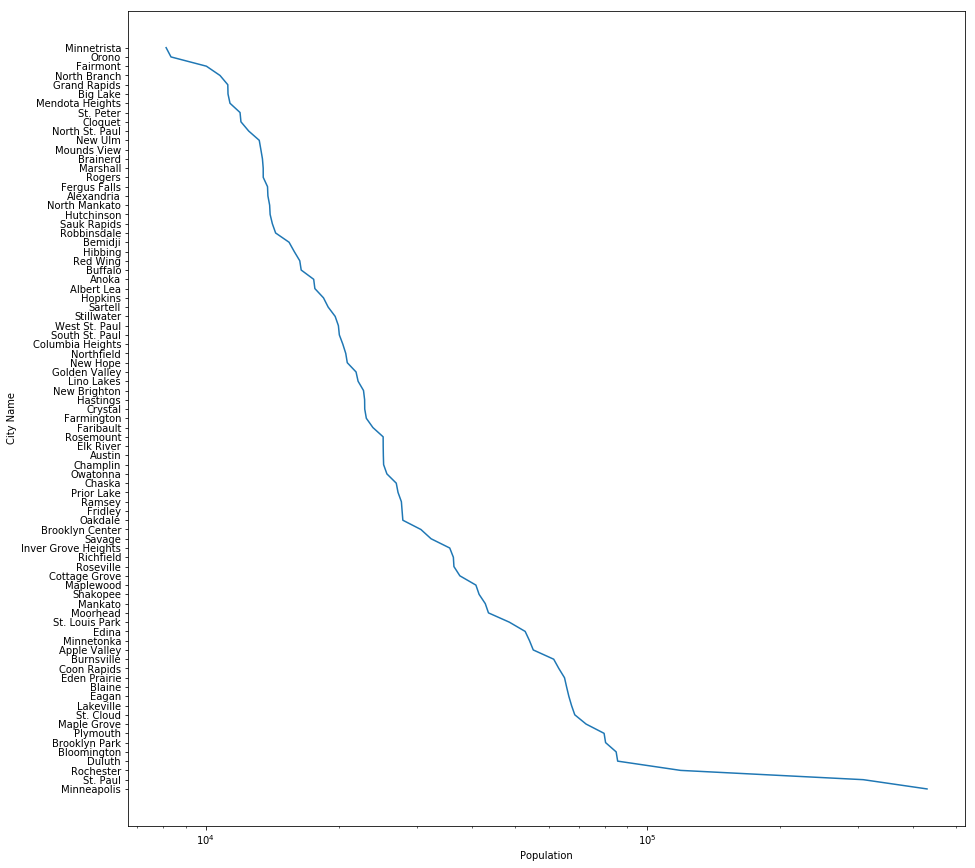

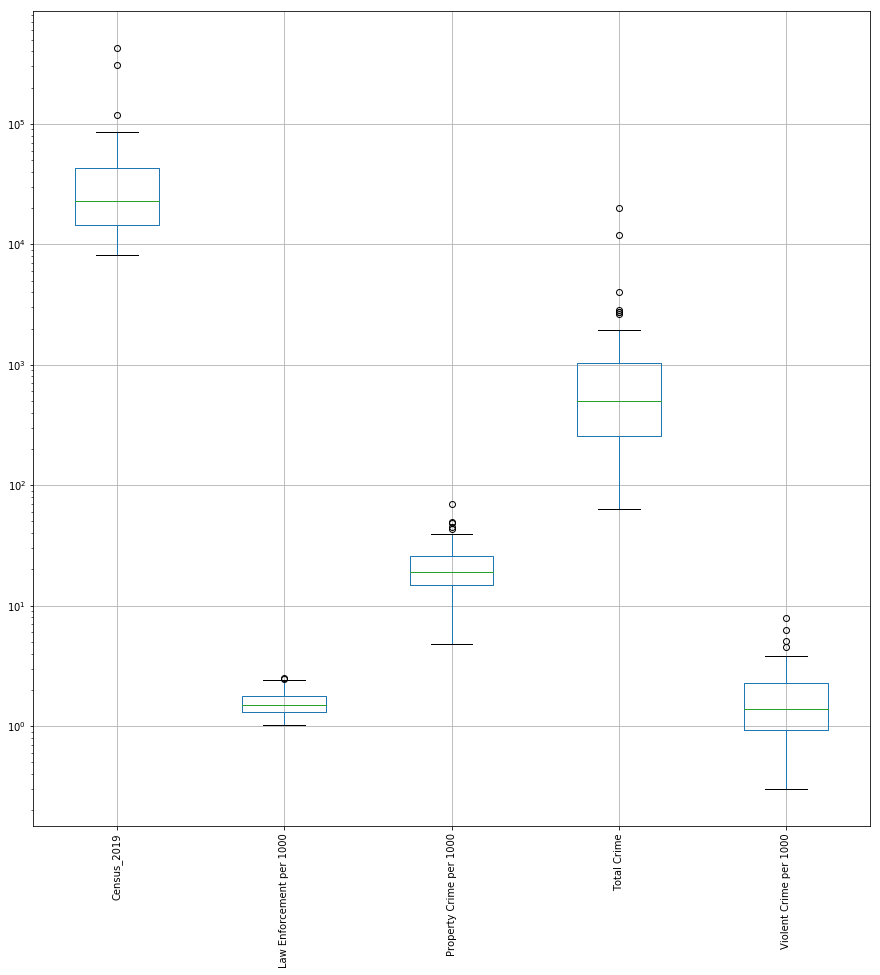

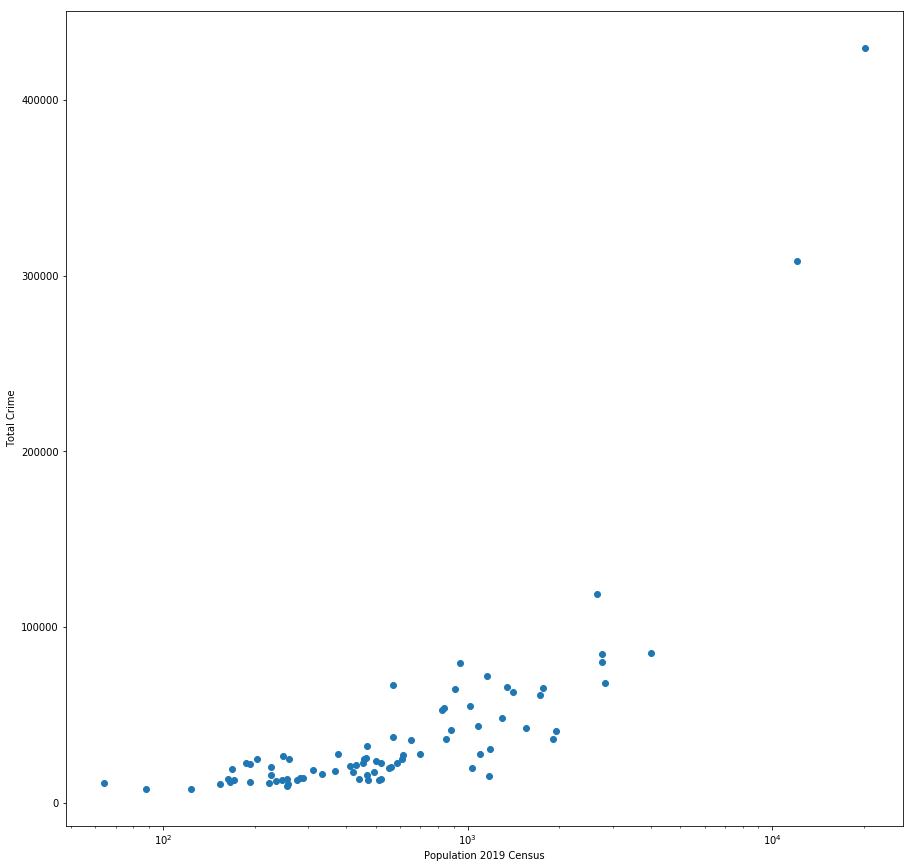

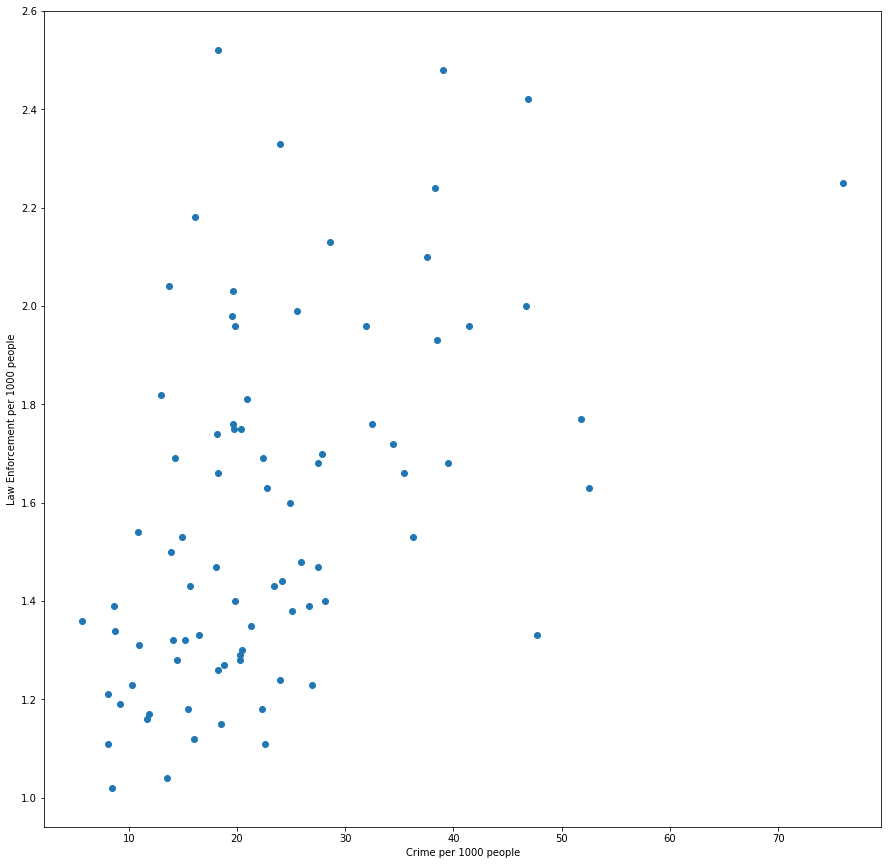

In [21]:
# ###########################################################################

# Exploratory Data Analysis

#PLot of cities by population
print('The three most populous cities in MN are: ')
print(df_city_data.nlargest(3,'Census_2019'))
print('The three least populous cities in MN are: ')
print(df_city_data.nsmallest(3,'Census_2019'))

figure(1,figsize=(15,15))
plt.plot(df_city_data['Census_2019'],df_city_data['Neighborhood'])
plt.xscale('log')
plt.xlabel('Population')
plt.ylabel('City Name')
plt.savefig(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\Course 8\p1.png')

#Box plot of parameters
figure(2,figsize=(15,15))
df_city_numeric.boxplot(rot=90)
plt.yscale('log')
plt.savefig(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\Course 8\bx1.png')


# Plot of population vs total crime
figure(3,figsize=(15,15))
plt.scatter(df_city_numeric['Total Crime'],df_city_numeric['Census_2019'])
plt.xscale('Log')
plt.xlabel('Population 2019 Census')
plt.ylabel('Total Crime')
plt.savefig(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\Course 8\p2.png')


# Plot of Ratio of Total Crime per 1000 vs Law Enforcement per 1000
figure(4,figsize=(15,15))
#df_city_data['Crime per 1000']=1000*df_city_data['Total Crime'].div(df_city_data['Census_2019'])
plt.scatter(df_city_data['Crime per 1000'],df_city_data['Law Enforcement per 1000'])
plt.xlabel('Crime per 1000 people')
plt.ylabel('Law Enforcement per 1000 people')
plt.savefig(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\Course 8\p3.png')
print("The city with highest Crime per 1000 people is : Bemidji")

##############################################################################



In [22]:
# 1 - Map showing cities located in Minnesota
# create map of Minnesota using location information
address = 'Minnesota, USA'
geolocator = Nominatim(user_agent='MN_explore')
location=geolocator.geocode(address)
latitude=location.latitude
longitude=location.longitude
map_MN=folium.Map(location=[latitude,longitude],zoom_start=6)
  
for lat, lng, borough, neighborhood in zip(MN_merged['latitude'], MN_merged['longitude'], MN_merged['Neighborhood'], MN_merged['County']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_MN)  
map_MN


,Census_2019,Law Enforcement per 1000,Property Crime per 1000,Total Crime,Violent Crime per 1000
Labels,,,,,
0,368851.000000,2.450000,35.830000,16084.000000,7.100000
1,16073.647059,1.949412,17.721765,313.705882,1.619412
2,37298.400000,1.436000,23.071000,907.700000,1.731000
3,15434.000000,2.250000,70.450000,1173.000000,5.090000
4,43016.307692,1.816154,37.340769,1735.923077,3.217692
5,32681.357143,1.280000,12.451786,455.892857,0.805714


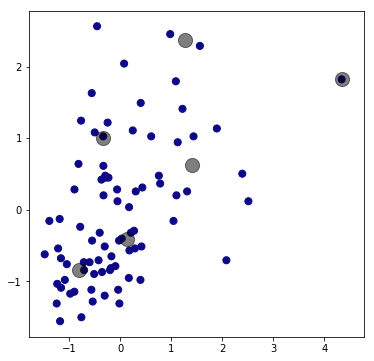

In [23]:
#Neighborhood classification using Kmeans based on population & safety
X=df_city_numeric
X = X.values[:,0:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
k_means = KMeans(init="k-means++", n_clusters=6, n_init=50)
k_means.fit(cluster_dataset)
k_mean_labels=k_means.labels_
y_means=k_means.predict(X)
centers = k_means.cluster_centers_
#Plot data
figure(1,figsize=(6,6))
plt.scatter(cluster_dataset[:, 2], cluster_dataset[:, 1], c=y_means, s=50, cmap='plasma')
plt.scatter(centers[:, 2], centers[:, 1], c='black', s=200, alpha=0.5);
df_city_numeric['Labels']=k_mean_labels
df_city_numeric.groupby('Labels').mean()

In [24]:
# Cluster data based on facilities available in the neighborhood

cluster_data=minnesota_grouped.drop('Neighborhood',1)
k_cluster=5
kmeans=KMeans(n_clusters=k_cluster,random_state=0).fit(cluster_data)
labels=kmeans.labels_
centers = kmeans.cluster_centers_
y_means=kmeans.predict(cluster_data)
cluster_data['Labels']=labels
cluster_data.groupby('Labels').mean()
MN_data_classified=cluster_data
MN_data_classified['city']=minnesota_grouped['Neighborhood']
MN_data_classified.set_index('city',inplace=True)
#MN_data_classified.to_csv(r'C:\Users\shend\Desktop\courses\IBM_data_analytics\MN_classified.csv')
# create map
MN_merged['Labels']=labels
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=6)

# set color scheme for the clusters
x = np.arange(k_cluster)
ys = [i + x + (i*x)**2 for i in range(k_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(MN_merged['latitude'], MN_merged['longitude'], MN_merged['Neighborhood'], MN_merged['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters